In [1]:
# import sys
# !{sys.executable} -m pip install xgboost

  Using cached xgboost-1.7.6-py3-none-win_amd64.whl (70.9 MB)


In [11]:
# import sys
# !{sys.executable} -m pip install shap

     ------------------------------------ 435.6/435.6 kB 353.6 kB/s eta 0:00:00


In [13]:

# import the dataset from Sklearn
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
import shap

In [5]:
# Read the DataFrame, first using the feature data
data = load_breast_cancer() 
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add a target column, and fill it with the target data
df['target'] = data.target

# Show the first five rows
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [8]:
# Set up the data for modelling 
y=df['target'].to_frame() # define Y
X=df[df.columns.difference(['target'])] # define X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # create train and test

# build model - Xgboost
xgb_mod=xgb.XGBClassifier(random_state=42,gpu_id=0) # build classifier
xgb_mod=xgb_mod.fit(X_train,y_train.values.ravel()) 

# make prediction and check model accuracy 
y_pred = xgb_mod.predict(X_test)

# Performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.37%


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


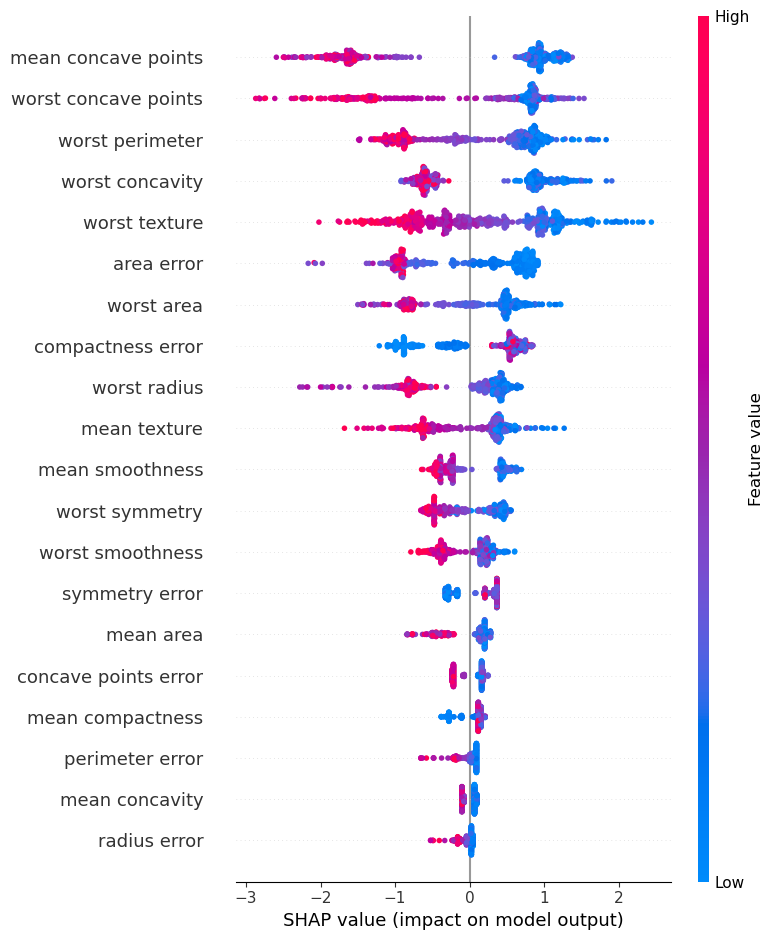

In [14]:
# Generate the Tree explainer and SHAP values
explainer = shap.TreeExplainer(xgb_mod)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

############## visualizations #############
# Generate summary dot plot
shap.summary_plot(shap_values, X,title="SHAP summary plot") 

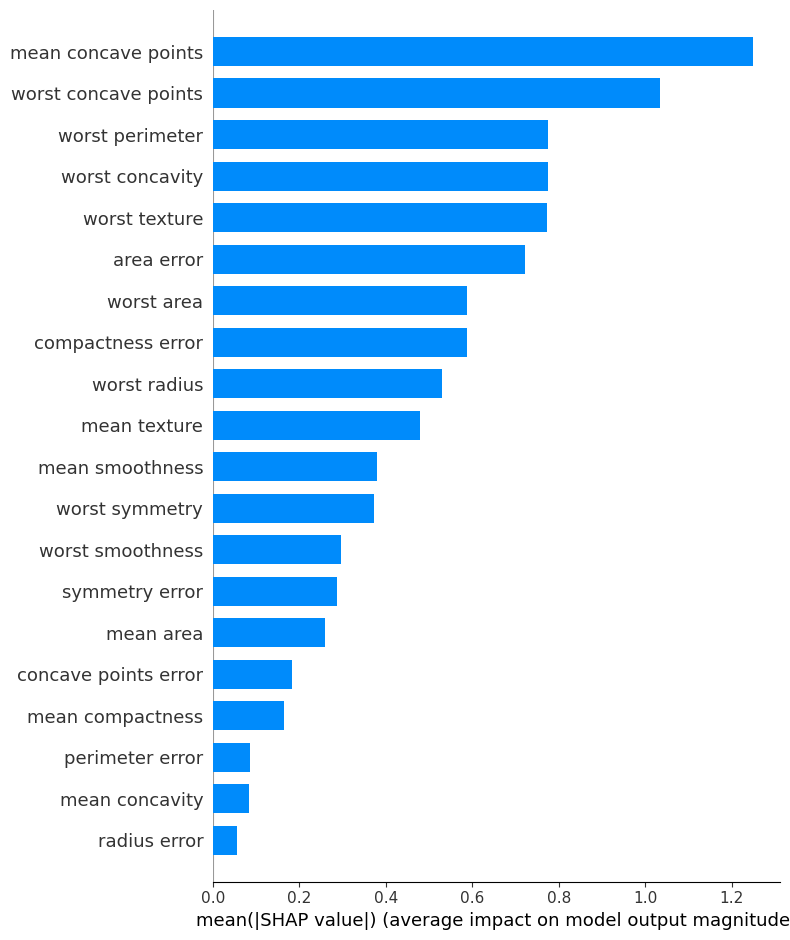

In [15]:
# Generate summary bar plot 
shap.summary_plot(shap_values, X,plot_type="bar") 

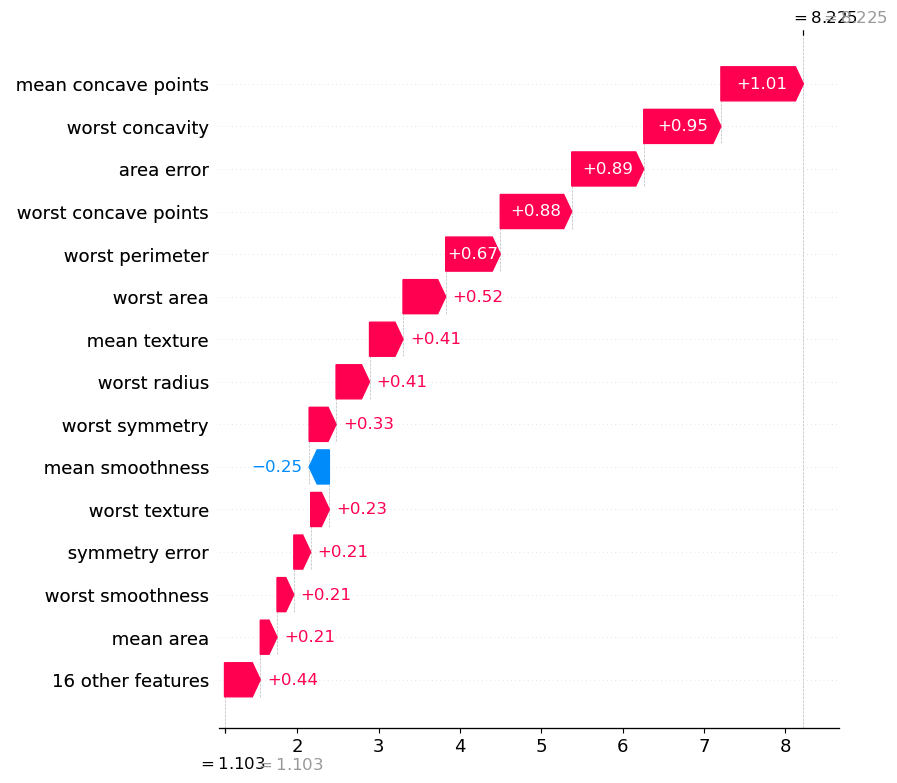

In [16]:
# Generate waterfall plot  
shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[79], features=X.loc[79,:], feature_names=X.columns, max_display=15, show=True)

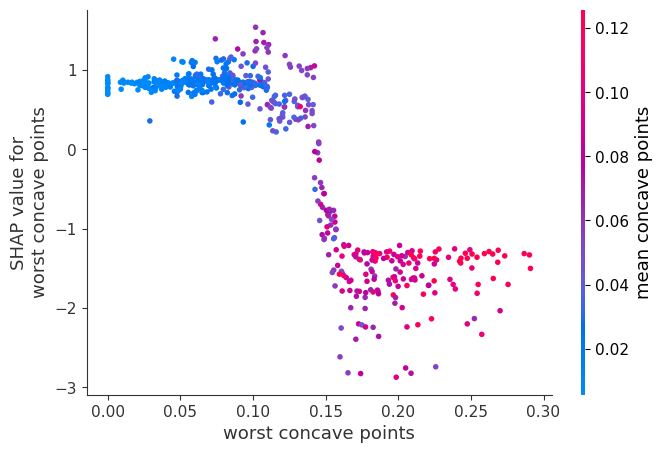

In [17]:

# Generate dependence plot
shap.dependence_plot("worst concave points", shap_values, X, interaction_index="mean concave points")

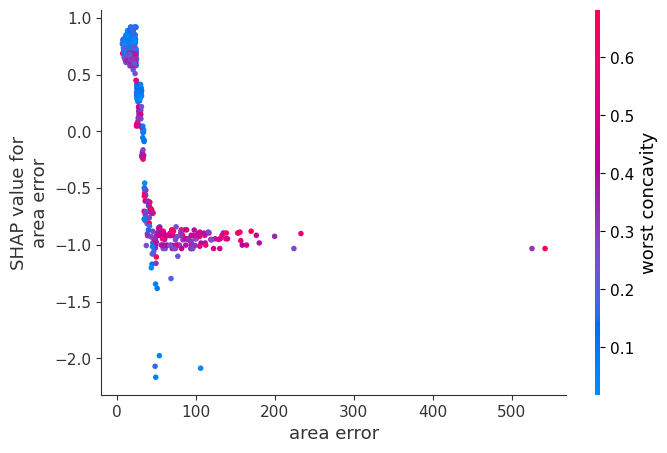

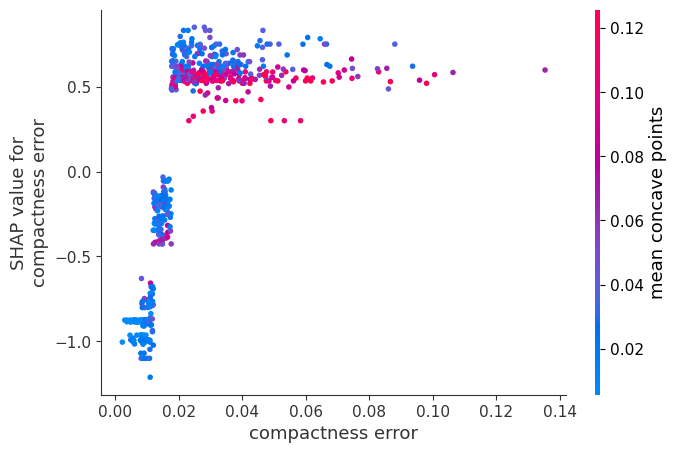

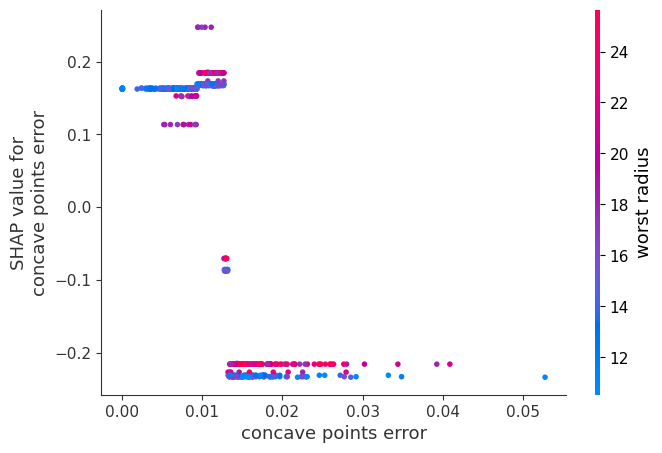

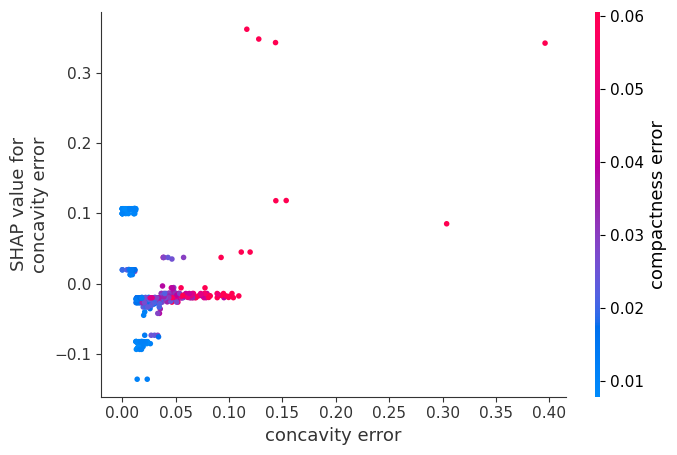

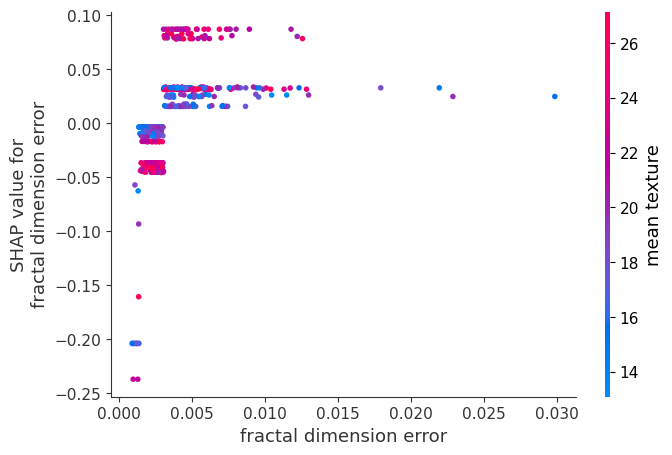

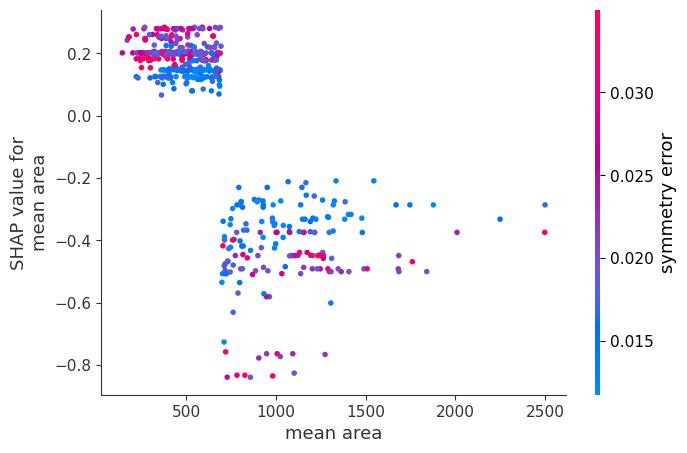

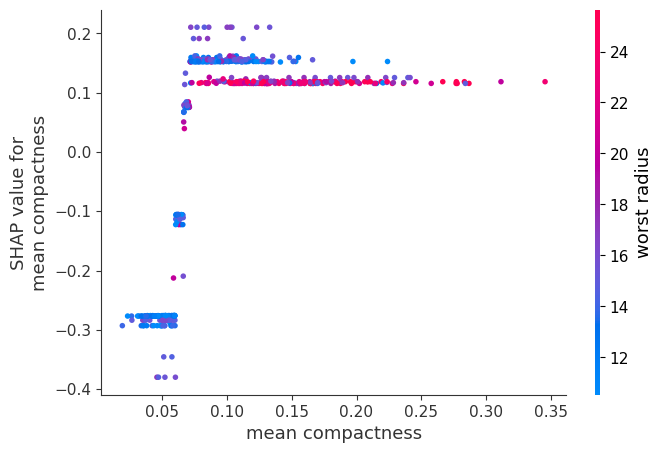

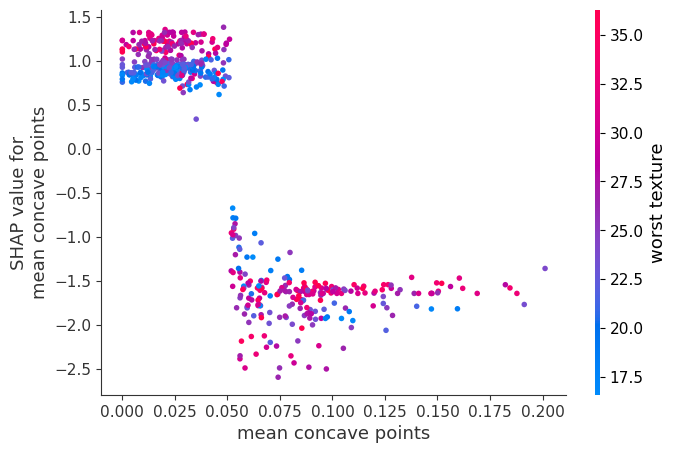

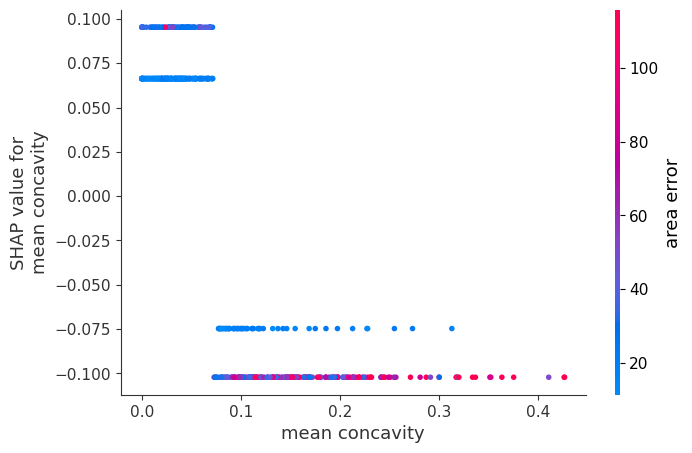

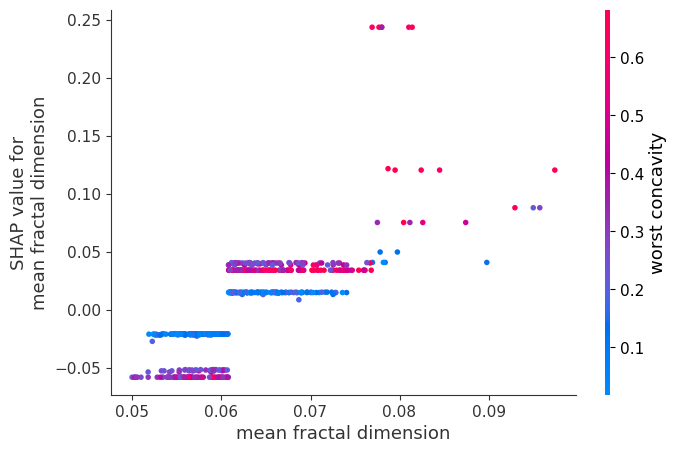

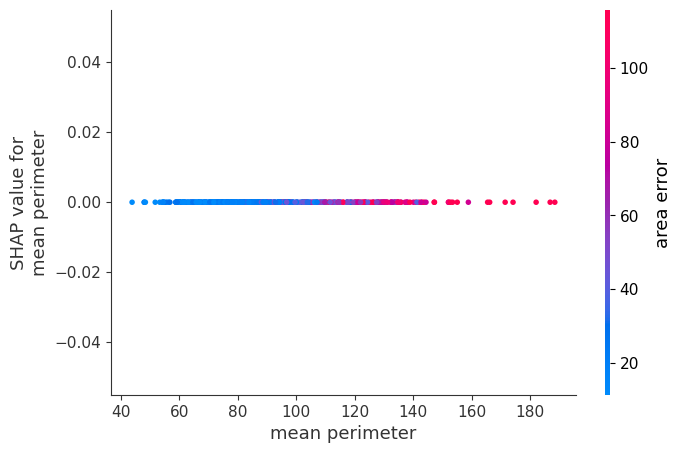

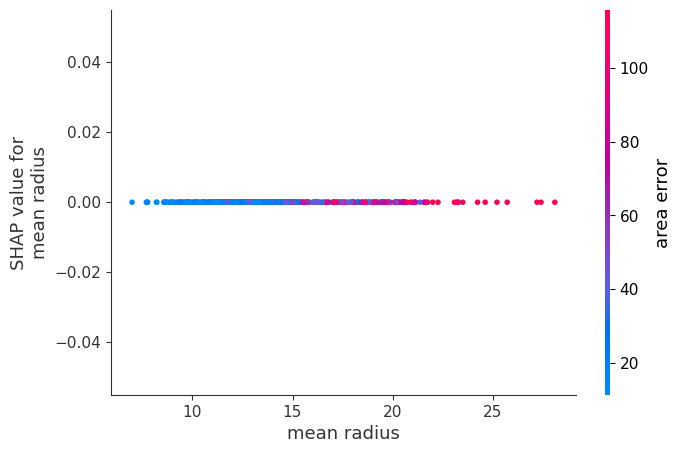

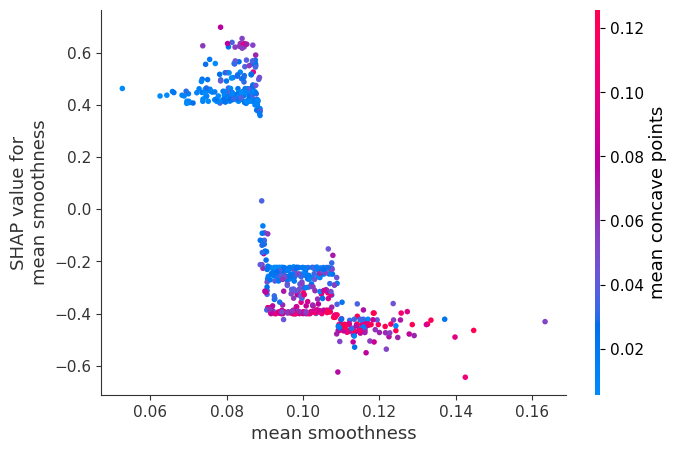

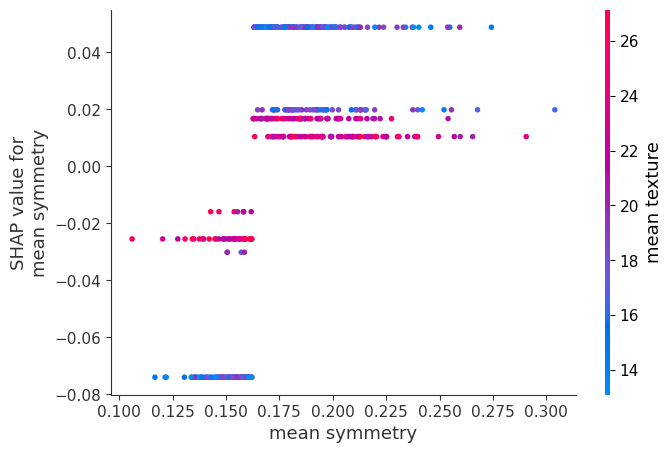

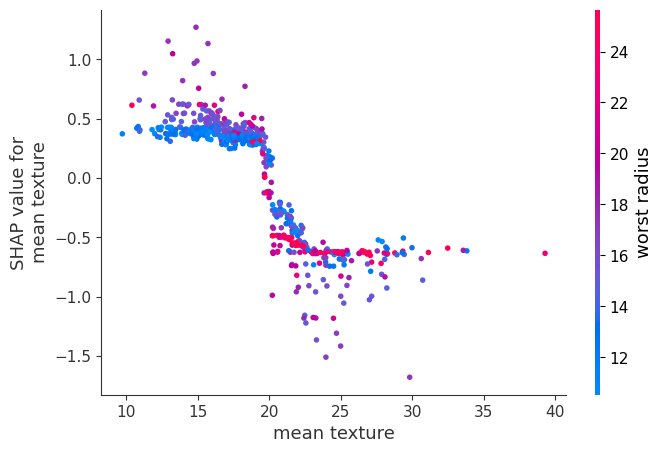

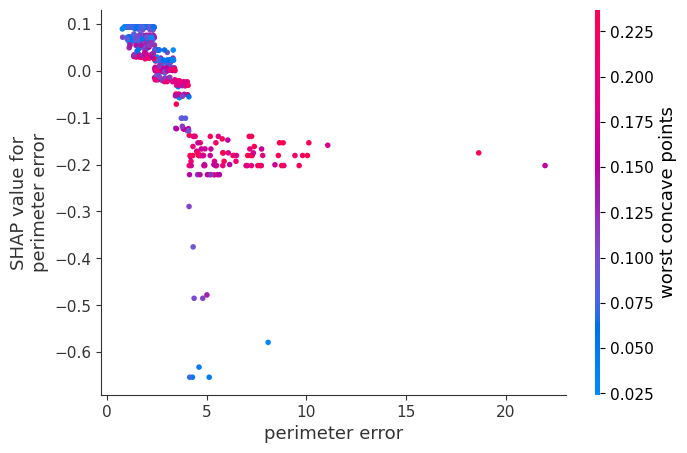

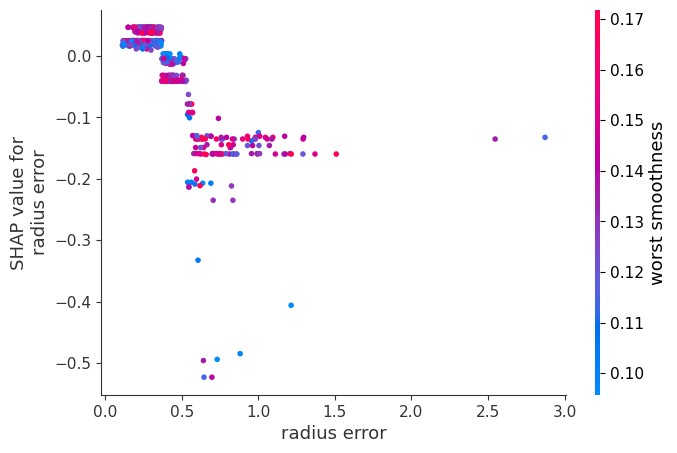

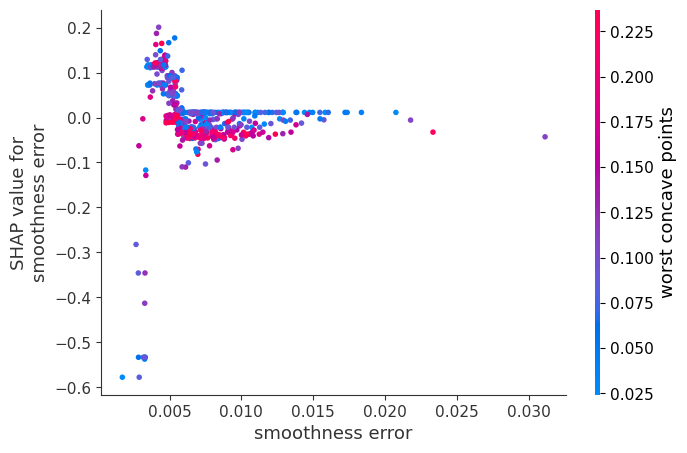

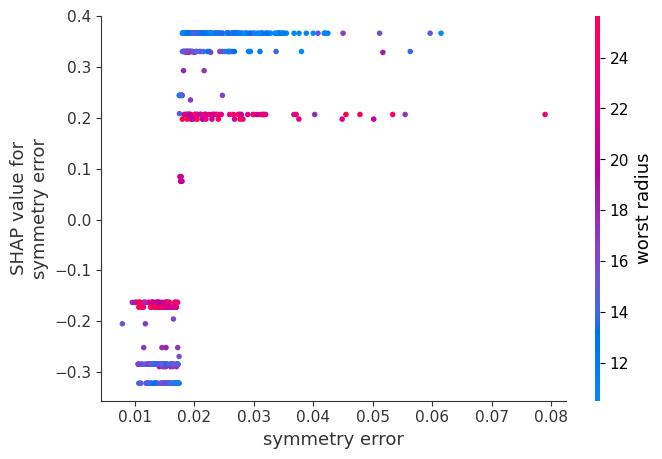

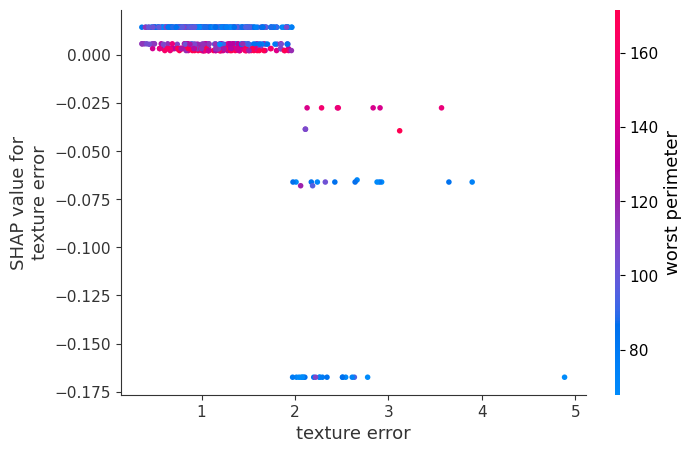

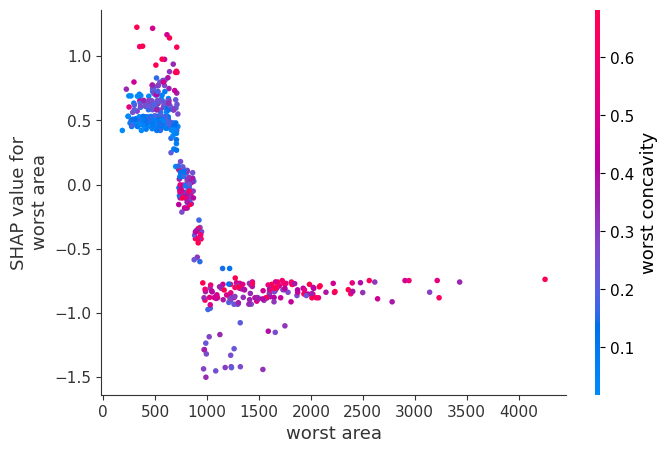

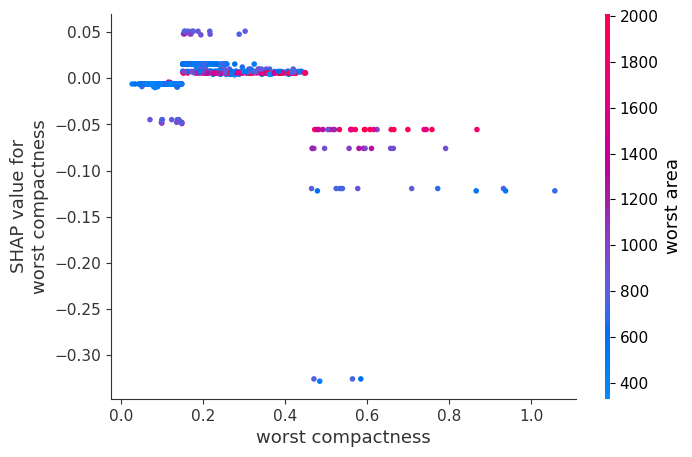

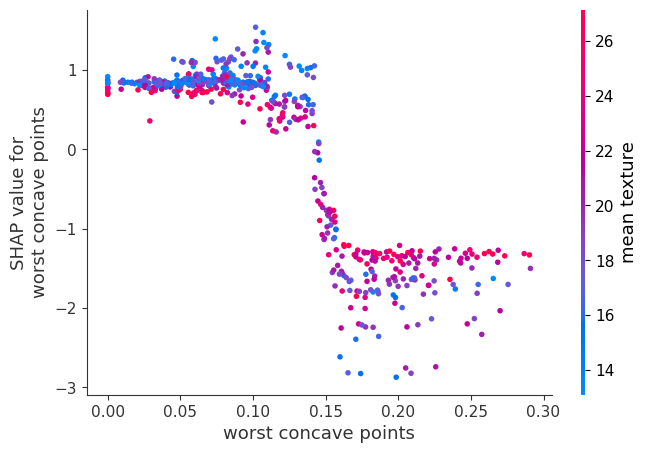

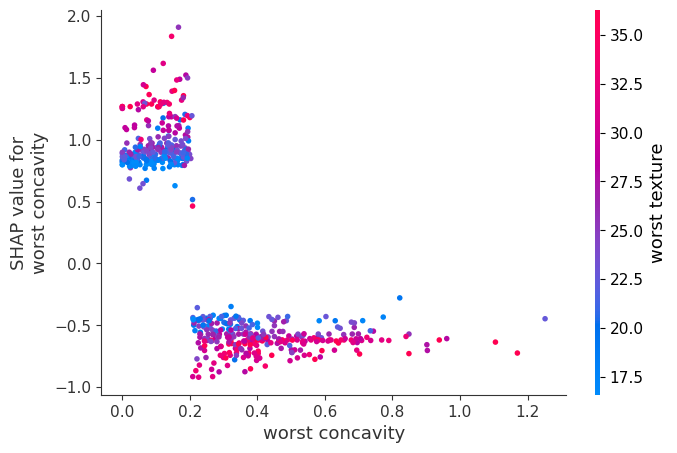

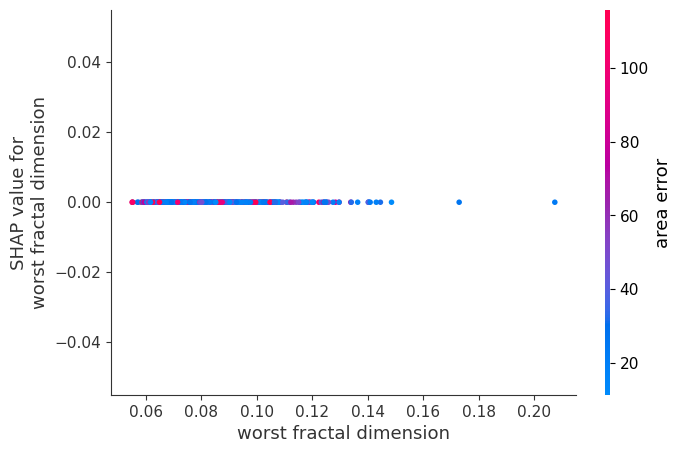

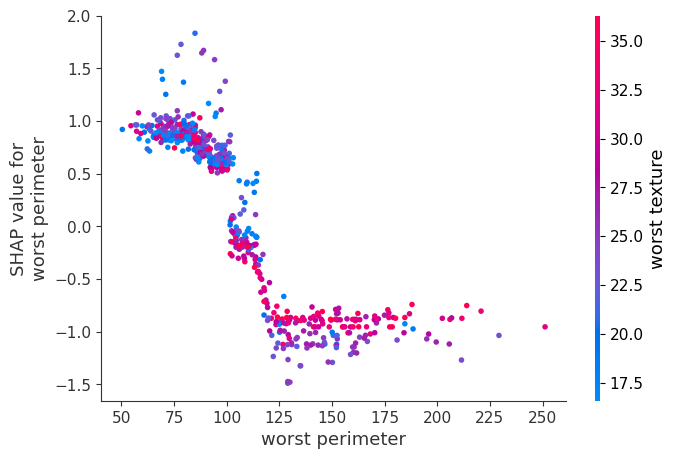

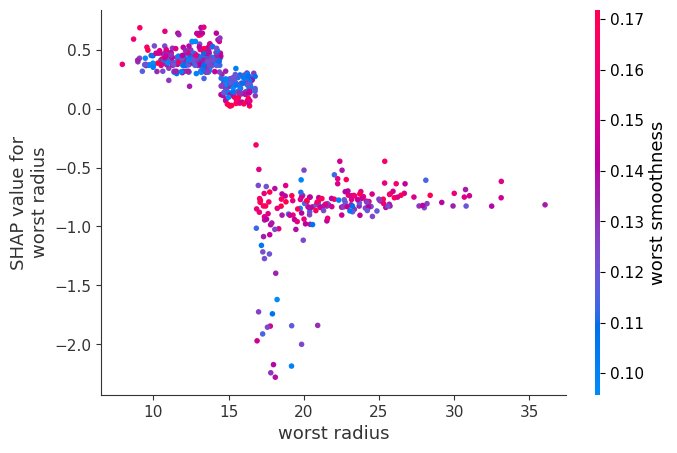

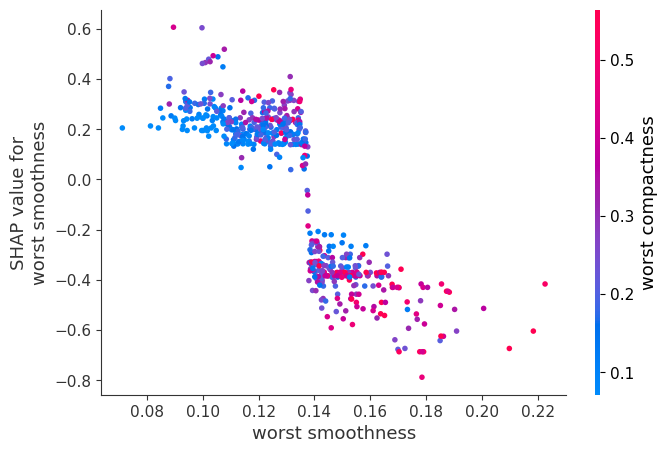

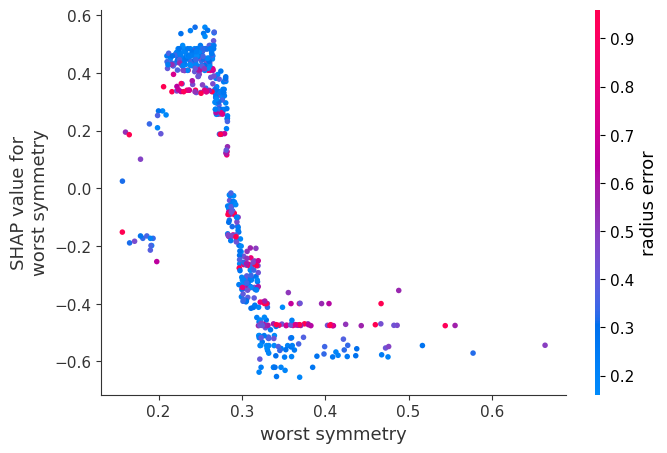

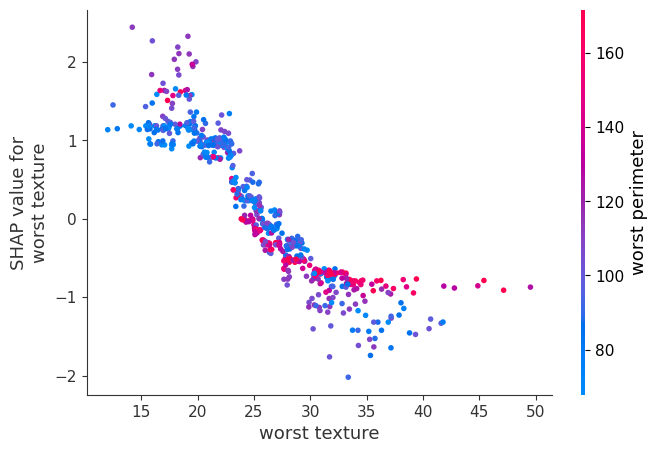

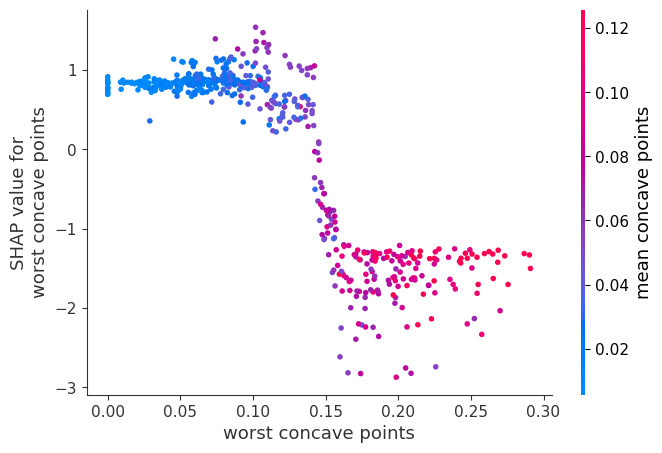

In [18]:

# Generate multiple dependence plots
for name in X_train.columns:
     shap.dependence_plot(name, shap_values, X)
shap.dependence_plot("worst concave points", shap_values, X, interaction_index="mean concave points")



In [22]:
# Generate force plot - Multiple rows 
shap.force_plot(explainer.expected_value, shap_values[:100,:], X.iloc[:100,:])

In [20]:

# Generate force plot - Single
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

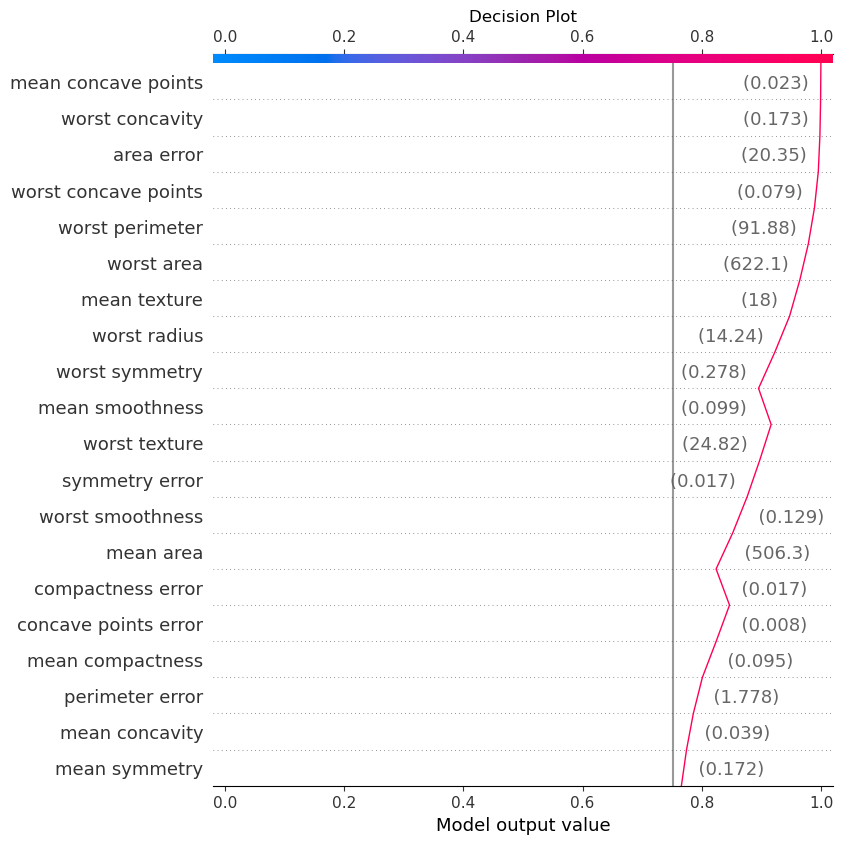

In [21]:

# Generate Decision plot 
shap.decision_plot(expected_value, shap_values[79],link='logit' ,features=X.loc[79,:], feature_names=(X.columns.tolist()),show=True,title="Decision Plot")